<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 1:

Our `DNN` will consist of 784 input nodes, a hidden layer with `128 nodes` and 10 output nodes (corresponding to the 10 digits). We use `mnist.load_data()` to get the 70,000 images divided into a set of 60,000 training images and 10,000 test images. We hold back 5,000 of the 60,000 training images for validation. After training the model, we group the 60,000 `activation values` of the hidden node for the (original) set of training images by the 10 predicted classes and visualize these sets of values using a `boxplot`. We expect the overlap between the range of values in the "boxes" to be minimal.

## Import packages 

Since Keras in part of TensorFlow 2.x, we import keras from tensorflow and use tenserflow.keras.xxx to import all other Keras packages. The seed argument produces a deterministic sequence of tensors across multiple calls.

In [1]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.datasets import mnist
#from plot_keras_history import plot_history

### Verify TensorFlow Version and Keras Version

In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.3.0


In [3]:
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


## Step 1: Loading MNIST Dataset

The MNIST dataset of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. It comes prepackaged as part of tf.Keras. Use the `tf.keras.datasets.mnist.load_data` to the get these datasets (and the corresponding labels) as Numpy arrays.

In [5]:
(x_train, y_train), (x_test, y_test)= tf.keras.datasets.mnist.load_data()

* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of grayscale image data with shapes (num_samples, 28, 28).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## Step 2: EDA Training and Test Datasets

* Imported 60000 examples for training and 10000 examples for test 
* Imported 60000 labels for training and 10000 labels for test 

In [6]:
print('x_train:\t{}'.format(x_train.shape))
print('y_train:\t{}'.format(y_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(60000, 28, 28)
y_train:	(60000,)
x_test:		(10000, 28, 28)
y_test:		(10000,)


### Review labels for training dataset

In [7]:
print("First ten labels training dataset:\n {}\n".format(y_train[0:10]))

First ten labels training dataset:
 [5 0 4 1 9 2 1 3 1 4]



### Find frequency of each label in the training and test data

In [8]:
# from collections import Counter
Counter(y_train).most_common()

[(1, 6742),
 (7, 6265),
 (3, 6131),
 (2, 5958),
 (9, 5949),
 (0, 5923),
 (6, 5918),
 (8, 5851),
 (4, 5842),
 (5, 5421)]

In [9]:
Counter(y_test).most_common()

[(1, 1135),
 (2, 1032),
 (7, 1028),
 (3, 1010),
 (9, 1009),
 (4, 982),
 (0, 980),
 (8, 974),
 (6, 958),
 (5, 892)]

### Plot Examples

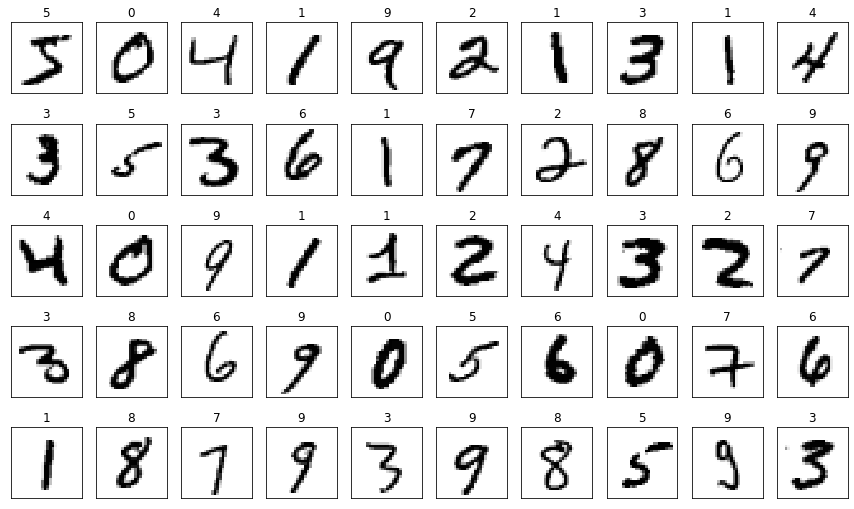

In [10]:
%matplotlib inline
fig = plt.figure(figsize = (15, 9))

for i in range(50):
    plt.subplot(5, 10, 1+i)
    plt.title(y_train[i])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].reshape(28,28), cmap='binary')

## Step 3: Preprocessing Data

### One Hot Encoding Labels

We will change the way this label is represented from a class name or number, to a vector of all possible classes with all the classes set to 0 except the one which this example belongs to - which will be set to 1. For example:


| original label | one-hot encoded label |
|------|------|
| 5 | [0, 0, 0, 0, 0, 1, 0, 0, 0, 0] |
| 7 | [0, 0, 0, 0, 0, 0, 0, 1, 0, 0] |
| 1 | [0, 1, 0, 0, 0, 0, 0, 0, 0, 0] |


In [11]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("First ten entries of y_train:\n {}\n".format(y_train[0:10]))
print("First ten rows of one-hot y_train:\n {}".format(y_train_encoded[0:10,]))

First ten entries of y_train:
 [5 0 4 1 9 2 1 3 1 4]

First ten rows of one-hot y_train:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [12]:
print('y_train_encoded shape: ', y_train_encoded.shape)
print('y_test_encoded shape: ', y_test_encoded.shape)

y_train_encoded shape:  (60000, 10)
y_test_encoded shape:  (10000, 10)


### Preprocessing the Examples
 numpy to unroll the examples from (28, 28) arrays to (784, 1) vectors

example shape before reshape

In [13]:
print('x_train:\t{}'.format(x_train.shape))
print('x_test:\t\t{}'.format(x_test.shape))

x_train:	(60000, 28, 28)
x_test:		(10000, 28, 28)


In [14]:
x_train_reshaped = np.reshape(x_train, (60000, 784))
x_test_reshaped = np.reshape(x_test, (10000, 784))

print('x_train_reshaped shape: ', x_train_reshaped.shape)
print('x_test_reshaped shape: ', x_test_reshaped.shape)

x_train_reshaped shape:  (60000, 784)
x_test_reshaped shape:  (10000, 784)


1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = Black
4. 255 = White

In [15]:
print(set(x_train_reshaped[0]))

{0, 1, 2, 3, 9, 11, 14, 16, 18, 23, 24, 25, 26, 27, 30, 35, 36, 39, 43, 45, 46, 49, 55, 56, 64, 66, 70, 78, 80, 81, 82, 90, 93, 94, 107, 108, 114, 119, 126, 127, 130, 132, 133, 135, 136, 139, 148, 150, 154, 156, 160, 166, 170, 171, 172, 175, 182, 183, 186, 187, 190, 195, 198, 201, 205, 207, 212, 213, 219, 221, 225, 226, 229, 238, 240, 241, 242, 244, 247, 249, 250, 251, 252, 253, 255}


In [16]:
np.set_printoptions(linewidth=np.inf)
print("{}".format(x_train[2020]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0 167 208  19   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  13 235 254  99   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  74 254 234   4   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 154 254 145   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 224 254  92   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  51 245 211  13   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   2 169 254 101   0   0   0   0   0   

In [17]:
x_train_norm = x_train_reshaped.astype('float32') / 255
x_test_norm = x_test_reshaped.astype('float32') / 255

In [18]:
print(set(x_train_norm[0]))

{0.0, 0.011764706, 0.53333336, 0.07058824, 0.49411765, 0.6862745, 0.101960786, 0.6509804, 1.0, 0.96862745, 0.49803922, 0.11764706, 0.14117648, 0.36862746, 0.6039216, 0.6666667, 0.043137256, 0.05490196, 0.03529412, 0.85882354, 0.7764706, 0.7137255, 0.94509804, 0.3137255, 0.6117647, 0.41960785, 0.25882354, 0.32156864, 0.21960784, 0.8039216, 0.8666667, 0.8980392, 0.52156866, 0.7882353, 0.18039216, 0.30588236, 0.44705883, 0.3529412, 0.15294118, 0.6745098, 0.9490196, 0.7647059, 0.88235295, 0.99215686, 0.2509804, 0.19215687, 0.93333334, 0.9843137, 0.74509805, 0.7294118, 0.5882353, 0.50980395, 0.8862745, 0.105882354, 0.09019608, 0.16862746, 0.13725491, 0.21568628, 0.46666667, 0.3647059, 0.27450982, 0.8352941, 0.7176471, 0.5803922, 0.8117647, 0.9764706, 0.83137256, 0.98039216, 0.95686275, 0.003921569, 0.73333335, 0.54509807, 0.5294118, 0.67058825, 0.007843138, 0.31764707, 0.0627451, 0.09411765, 0.42352942, 0.627451, 0.9411765, 0.9882353, 0.5176471, 0.09803922, 0.1764706}


## Step 4: Create the Model

### Specify a network architecture

Below is the neural network architecture we will use today for classifying MNIST digits.

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/DNN_architecture.png?raw=1">

### Build DNN Model

We use a Sequential class defined in Keras to create our model. All the layers are going to be Dense layers. This means, like our examples above, all the nodes of a layer would be connected to all the nodes of the preceding layer i.e. densely connected.

In [19]:
model = Sequential([
    Dense(name = "hidden_layer", units = 128, activation = tf.nn.relu, input_shape = (784,)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)
])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer (Dense)         (None, 128)               100480    
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


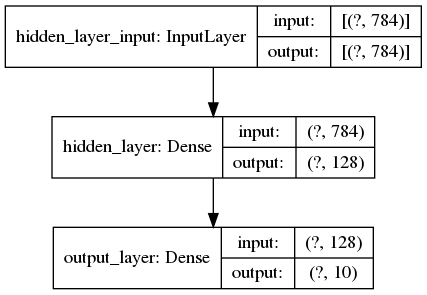

In [21]:
keras.utils.plot_model(model, "mnist_model.png", show_shapes=True) 

### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

In [22]:
model.compile(optimizer='rmsprop',           
               loss = 'categorical_crossentropy',
               metrics=['accuracy'])

## Step 5: Training the model

In [23]:
history = model.fit(
    x_train_norm,
    y_train_encoded,
    epochs = 10,
    validation_split=0.20 
    )

Epoch 1/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2882 - accuracy: 0.9183 - val_loss: 0.1612 - val_accuracy: 0.9544
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1362 - accuracy: 0.9604 - val_loss: 0.1224 - val_accuracy: 0.9653
Epoch 3/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0982 - accuracy: 0.9718 - val_loss: 0.1089 - val_accuracy: 0.9693
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0778 - accuracy: 0.9773 - val_loss: 0.1069 - val_accuracy: 0.9699
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0638 - accuracy: 0.9817 - val_loss: 0.0974 - val_accuracy: 0.9749
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0543 - accuracy: 0.9848 - val_loss: 0.0980 - val_accuracy: 0.9742
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0458 - accuracy: 0.9874 - val_loss: 0.1053 - val_accuracy:

validation_data = Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data

## Step 6: Test the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [24]:
loss, accuracy = model.evaluate(x_test_norm, y_test_encoded)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 1s 2ms/step - loss: 0.0929 - accuracy: 0.9773
test set accuracy:  97.72999882698059


## Task 7: Predictions

In [25]:
preds = model.predict(x_test_norm)
print('shape of preds: ', preds.shape)

shape of preds:  (10000, 10)


Look at the first 25 - Plot test set images along with their predicted and actual labels to understand how the trained model actually performed

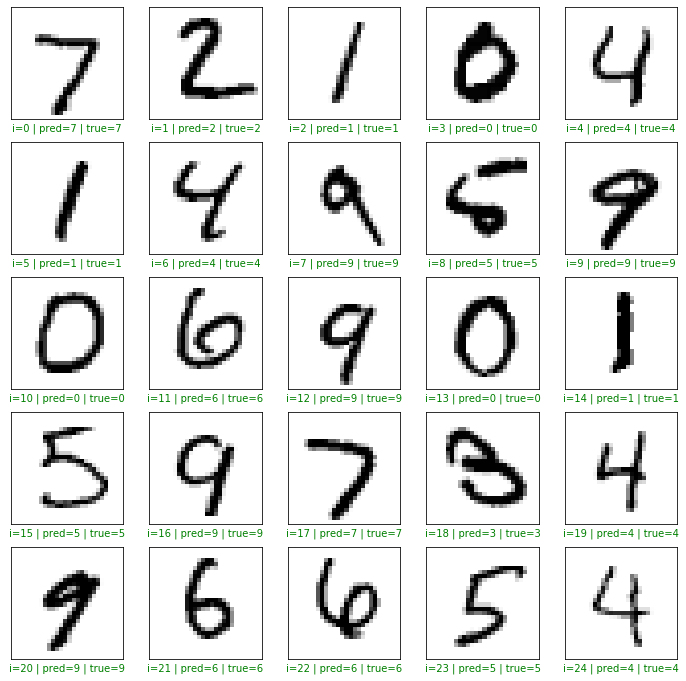

In [26]:
%matplotlib inline
plt.figure(figsize = (12, 12))

start_index = 0

for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = np.argmax(preds[start_index + i])
    actual = np.argmax(y_test_encoded[start_index + i])
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('i={} | pred={} | true={}'.format(start_index + i, pred, actual), color = col)
    plt.imshow(x_test[start_index + i], cmap='binary')
plt.show()

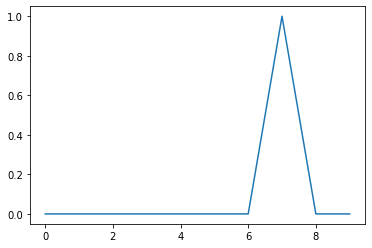

In [27]:
"""
Enter the index value in place of the value 17 below for the prediction
that you want to plot the probability scores for
"""
index = 17

plt.plot(preds[index])
plt.show()

### Review Performance

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Task 8: Plotting Performance Metrics 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [29]:
#plot_history(history.history)
#plt.show()

In [30]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

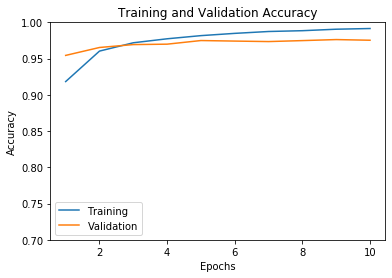

In [32]:
plt.plot(range(1, len(acc) + 1), history.history['accuracy'], label = 'Training')
plt.plot(range(1, len(val_acc) + 1), history.history['val_accuracy'], label = 'Validation')
plt.ylim([0.7, 1.0])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

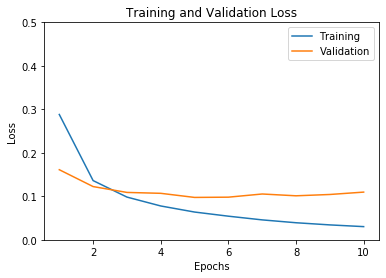

In [33]:
plt.plot(range(1, len(loss) + 1), history.history['loss'], label = 'Training')
plt.plot(range(1, len(val_loss) + 1), history.history['val_loss'], label = 'Validation')
plt.ylim([0.0, 0.5])
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Task 9: Creating confusion matrices

Let us see what the confusion matrix looks like. Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [34]:
# Get the predicted classes:
# pred_classes = model.predict_classes(x_train_norm)# give deprecation warning
pred_classes = np.argmax(model.predict(x_train_norm), axis=-1)
pred_classes

array([5, 0, 4, ..., 5, 6, 8])

In [35]:
conf_mx = tf.math.confusion_matrix(y_train, pred_classes)
conf_mx

<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[5870,    0,    7,    4,    1,    1,    4,    0,   25,   11],
       [   0, 6719,    6,    4,    4,    0,    2,    1,    6,    0],
       [   5,   10, 5885,   15,    2,    1,    1,    8,   30,    1],
       [   0,    6,   13, 6054,    1,   12,    1,    5,   32,    7],
       [   0,   10,    2,    0, 5796,    0,    5,    5,    3,   21],
       [   1,    2,    3,   19,    3, 5344,   14,    1,   23,   11],
       [   3,    2,    0,    0,    4,    4, 5892,    0,   13,    0],
       [   1,   17,   11,    3,    6,    4,    0, 6201,    4,   18],
       [   2,    6,    3,    8,    1,    5,    0,    4, 5818,    4],
       [   4,    4,    0,   12,   13,    7,    1,   14,   16, 5878]], dtype=int32)>

### Visualizing the confusion matrix

We use code from chapter 3 of Hands on Machine Learning (A. Geron) (cf. https://github.com/ageron/handson-ml2/blob/master/03_classification.ipynb) to display a "heat map" of the confusion matrix. Then we normalize the confusion matrix so we can compare error rates. 

See https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch03.html#classification_chapter

In [36]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Note that the rows represent actual classes while the columns represent predicted classes.

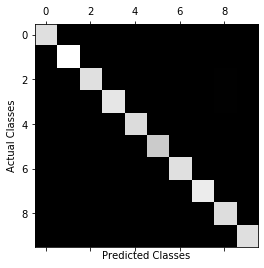

In [37]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

The confusion matrix looks quite good!

Looks like 28 fours were misclassified as nines (and 10 nines were classifed fours). We display some of these misclassfications along with exam of fours and nines that were correctly identified.

In [38]:
def plot_digits(instances, pos, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    pos.imshow(image, cmap = 'binary', **options)
    pos.axis("off")

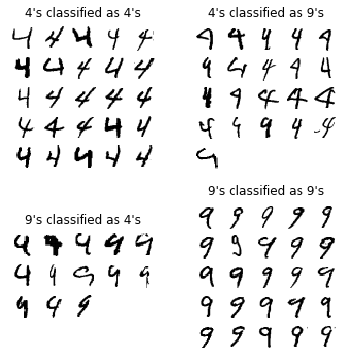

In [39]:
cl_a, cl_b = 4, 9
X_aa = x_train_norm[(y_train == cl_a) & (pred_classes == cl_a)]
X_ab = x_train_norm[(y_train == cl_a) & (pred_classes == cl_b)]
X_ba = x_train_norm[(y_train == cl_b) & (pred_classes == cl_a)]
X_bb = x_train_norm[(y_train == cl_b) & (pred_classes == cl_b)]

plt.figure(figsize=(6,6))

p1 = plt.subplot(221)
p2 = plt.subplot(222)
p3 = plt.subplot(223)
p4 = plt.subplot(224)

plot_digits(X_aa[:25], p1, images_per_row=5);
plot_digits(X_ab[:25], p2, images_per_row=5);
plot_digits(X_ba[:25], p3, images_per_row=5);  
plot_digits(X_bb[:25], p4, images_per_row=5);


p1.set_title(f"{cl_a}'s classified as {cl_a}'s")
p2.set_title(f"{cl_a}'s classified as {cl_b}'s")
p3.set_title(f"{cl_b}'s classified as {cl_a}'s")
p4.set_title(f"{cl_b}'s classified as {cl_b}'s")

# plt.savefig("error_analysis_digits_plot_EXP1_valid")

plt.show()

First, display 50 of the 4's classified correctly...

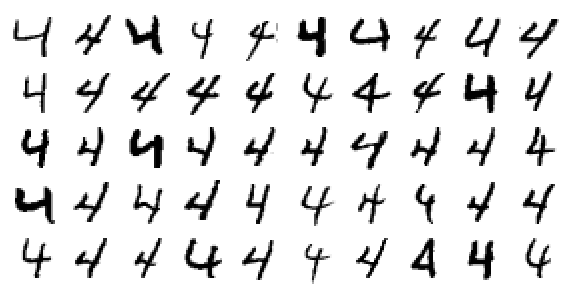

In [40]:
# display 50 of the 4's classified correctly
plt.figure(figsize=(10,10))
plot_digits(X_aa[:50],plt,images_per_row = 10)

Then all the 4's classified as 9's...

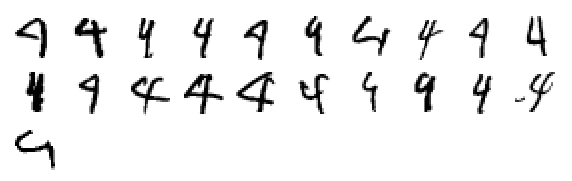

In [41]:
num = X_ab.shape[0]
plt.figure(figsize=(10,10))
plot_digits(X_ab[:num],plt, images_per_row = 10)

Then display 50 of the 9's classified correctly

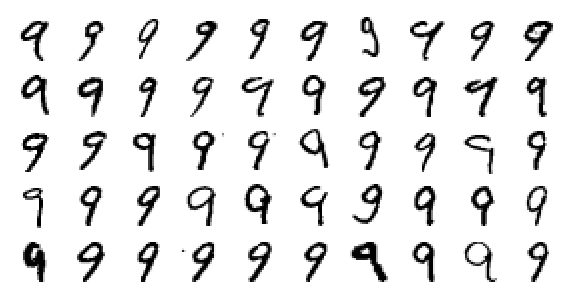

In [42]:
plt.figure(figsize=(10,10))
plot_digits(X_bb[:50],plt, images_per_row = 10)

Finally, display al the 9's classified as 4's.

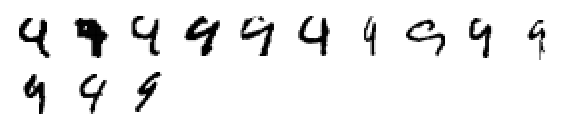

In [43]:
# display all the 7's classified as 3's
num = X_ba.shape[0]
plt.figure(figsize=(10,10))
plot_digits(X_ba[:num],plt, images_per_row = 10)

## Task 10: Analyzing the activation values of the hidden nodes

We want to examine the contribution of the individual hidden nodes to the classifications made by the model. We first get the activation values of all the hidden nodes for each of the 60,000 training images and treat these *128 activations* as the features that determine the classification class. For the sake of comparison,  we also consider the *784 pixels* of each training image and determine the contribution of the individual pixels to the predicted classification class. 

Our goal is to use *box* and *scatter* plots to visualize how these features (*pixel* and *activiation* values) correlate with the predicted classes. Because of the high dimension of the feature spaces, we apply *PCA decomposition* and *t-Distributed stochastic neighbor embedding* (`t-SNE`) to reduce the number of features in each case. 

We use the following two articles as reference

 * https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
 * https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b


1) Raw data is 60,000 X 784. Just do a scatter plot of col 1 vs col 2. Overlay the color coded classes. We  should not see any patterns since there is not much info in 2 cols to discriminate.

2) PCA of raw data – as we discussed earlier. Plot PC1 vs PC2 with overlay. This should be ‘better’ since these 2 capture the info from all 784 cols.

3) PCA of activation values – as we discussed earlier. This should be ‘better’ than the previous 2 since it has captured specific features of discrimination.

 ### Step 1: Getting the activation values of the hidden nodes
 
To get the activation values of the hidden nodes, we need to create a new model, `activation_model`, that takes the same input as our current model but outputs the activation value of the hidden layer, i.e. of the hidden node. Then use the `predict` function to get the activation values.

In [44]:
# Extracts the outputs of the 2 layers:
layer_outputs = [layer.output for layer in model.layers]

# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

print(f"There are {len(layer_outputs)} layers")
layer_outputs # description of the layers

There are 2 layers


[<tf.Tensor 'hidden_layer/Relu:0' shape=(None, 128) dtype=float32>,
 <tf.Tensor 'output_layer/Softmax:0' shape=(None, 10) dtype=float32>]

In [45]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(x_train_norm)
hidden_layer_activation = activations[0]
output_layer_activations = activations[1]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

(60000, 128)

In [46]:
output_layer_activations.shape

(60000, 10)

In [47]:
print(f"The maximum activation value of the hidden nodes in the hidden layer is \
{hidden_layer_activation.max()}")

The maximum activation value of the hidden nodes in the hidden layer is 22.377239227294922


In [48]:
# Some stats about the output layer as an aside...
np.set_printoptions(suppress = True)  # display probabilities as decimals and NOT in scientific notation
ouput_layer_activation = activations[1]
print(f"The output node has shape {ouput_layer_activation.shape}")
print(f"The output for the first image are {ouput_layer_activation[0].round(4)}")
print(f"The sum of the probabilities is (approximately) {ouput_layer_activation[0].sum()}")

The output node has shape (60000, 10)
The output for the first image are [0.     0.     0.     0.0114 0.     0.9886 0.     0.     0.     0.    ]
The sum of the probabilities is (approximately) 1.0


 ### Step 2: Creating a dataframe with the activation values and predicted classes

In [49]:
#Get the dataframe of all the node values
activation_data = {'pred_class':pred_classes}
for k in range(0,128): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head()

,pred_class,act_val_0,act_val_1,act_val_2,act_val_3,act_val_4,act_val_5,act_val_6,act_val_7,act_val_8,...,act_val_118,act_val_119,act_val_120,act_val_121,act_val_122,act_val_123,act_val_124,act_val_125,act_val_126,act_val_127
0,5,0.000000,5.11325,3.703687,3.742224,0.000000,5.818872,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2.596694,1.573130,0.000000,0.206691,1.576145
1,0,0.000000,0.00000,3.226969,0.000000,0.549231,0.000000,2.010682,0.000000,0.000000,...,0.698426,2.588680,0.000000,0.546940,1.499180,0.000000,0.000000,1.865126,0.000000,0.000000
2,4,1.592515,0.00000,1.541143,0.000000,4.580981,0.000000,2.013930,1.202855,5.273721,...,0.000000,3.456670,1.600987,0.000000,5.517612,1.453676,0.000000,0.000000,0.644546,0.237385
3,1,0.000000,0.00000,0.000000,3.477162,0.000000,1.347968,0.000000,0.000000,0.000000,...,0.000000,2.982585,0.000000,0.000000,4.574988,0.788229,1.198567,0.000000,0.000000,1.626707
4,9,0.000000,0.00000,0.796327,0.000000,3.179304,2.424907,3.931662,0.000000,2.209432,...,3.351787,1.295640,0.000000,2.642335,5.751868,0.000000,0.000000,2.253416,0.000000,2.283725


 ### Step 3: Visualualizing the activation values with boxplots
 
We get the activation values of the first hidden node and combine them with the corresponding predicted classes into a DataFrame. We use both `matplotlib` and `seaborn` to create boxplots from the dataframe. 

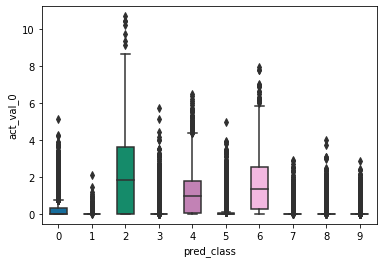

In [50]:
# To see how closely the hidden node activation values correlate with the class predictions
# Let us use seaborn for the boxplots this time.
bplot = sns.boxplot(y='act_val_0', x='pred_class', 
                 data=activation_df[['act_val_0','pred_class']], 
                 width=0.5,
                 palette="colorblind")

 ### Step 4: Creating a dataframe with the pixel values and predicted classes

In [51]:
#Get the dataframe of all the pixel values
pixel_data = {'pred_class':pred_classes}
for k in range(0,784): 
    pixel_data[f"pix_val_{k}"] = x_train_norm[:,k]
pixel_df = pd.DataFrame(pixel_data)
pixel_df.head()

,pred_class,pix_val_0,pix_val_1,pix_val_2,pix_val_3,pix_val_4,pix_val_5,pix_val_6,pix_val_7,pix_val_8,...,pix_val_774,pix_val_775,pix_val_776,pix_val_777,pix_val_778,pix_val_779,pix_val_780,pix_val_781,pix_val_782,pix_val_783
0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
pixel_df.pix_val_77.value_counts()

0.000000    59720
1.000000       25
0.996078       13
0.992157        9
0.050980        6
            ...  
0.392157        1
0.717647        1
0.215686        1
0.925490        1
0.937255        1
Name: pix_val_77, Length: 150, dtype: int64

In [53]:
pixel_df.pix_val_78.value_counts()

0.000000    59862
1.000000        6
0.141176        4
0.960784        4
0.992157        4
            ...  
0.749020        1
0.717647        1
0.345098        1
0.968627        1
0.654902        1
Name: pix_val_78, Length: 97, dtype: int64

### Step 5:  Using a scatter plot to visualize the contribution of two pixel location values to the predicated classes

We use a scatter plot to determine the correlation between the `pix_val_77` and `pix_val_78` values and the `pred_class` values.

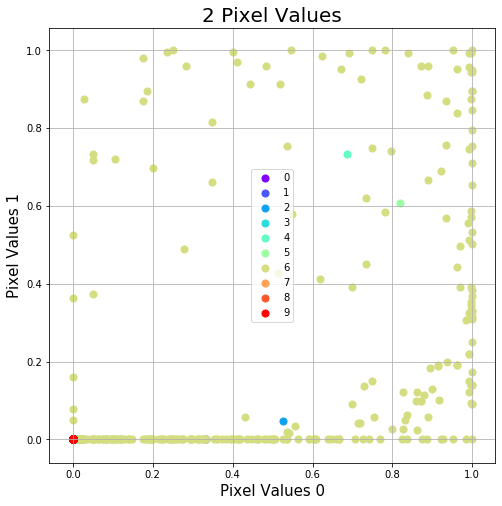

In [54]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Pixel Values 0', fontsize = 15)
ax.set_ylabel('Pixel Values 1', fontsize = 15)
ax.set_title('2 Pixel Values', fontsize = 20)
targets = [0,1,2,3,4,5,6,7,8,9]
#colors = ['r', 'g', 'b']
from matplotlib import cm


colors = cm.rainbow(np.linspace(0, 1, 10))

for target, color in zip(targets,colors):
    indicesToKeep = pixel_df['pred_class'] == target
    ax.scatter(pixel_df.loc[indicesToKeep, 'pix_val_77']
               , pixel_df.loc[indicesToKeep, 'pix_val_78']
               , c = color.reshape(1,-1)
               , s = 50)
ax.legend(targets)
ax.grid()

## PCA Feature Reduction / Model Optimization 

### Step 6:  Use PCA decomposition to reduce the number of features from 784 features to 2 features 

In [55]:
# from sklearn.decomposition import PCA

# Separating out the features
features = [*pixel_data][1:] # ['pix_val_0', 'pix_val_1',...]
x = pixel_df.loc[:, features].values 

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [56]:
pixel_pca_df = pd.concat([principalDf, pixel_df[['pred_class']]], axis = 1)

In [57]:
pixel_pca_df.head()

,principal component 1,principal component 2,pred_class
0,0.486045,-1.226387,5
1,3.967530,-1.156284,0
2,-0.203335,1.537953,4
3,-3.133834,-2.381170,1
4,-1.501000,2.864955,9


In [58]:
pca.explained_variance_ratio_

array([0.09704666, 0.07095926], dtype=float32)

### Step 7:  Using a scatter plot to visualize the contribution of two principal component values to the predicated class values

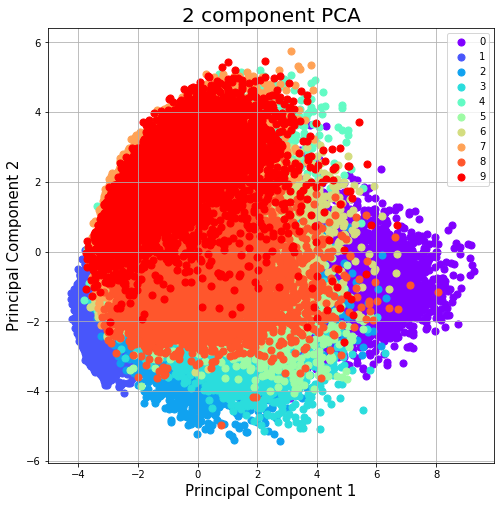

In [59]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2,3,4,5,6,7,8,9]
#colors = ['r', 'g', 'b']
from matplotlib import cm


colors = cm.rainbow(np.linspace(0, 1, 10))

for target, color in zip(targets,colors):
    indicesToKeep = pixel_pca_df['pred_class'] == target
    ax.scatter(pixel_pca_df.loc[indicesToKeep, 'principal component 1']
               , pixel_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color.reshape(1,-1)
               , s = 50)
ax.legend(targets)
ax.grid()

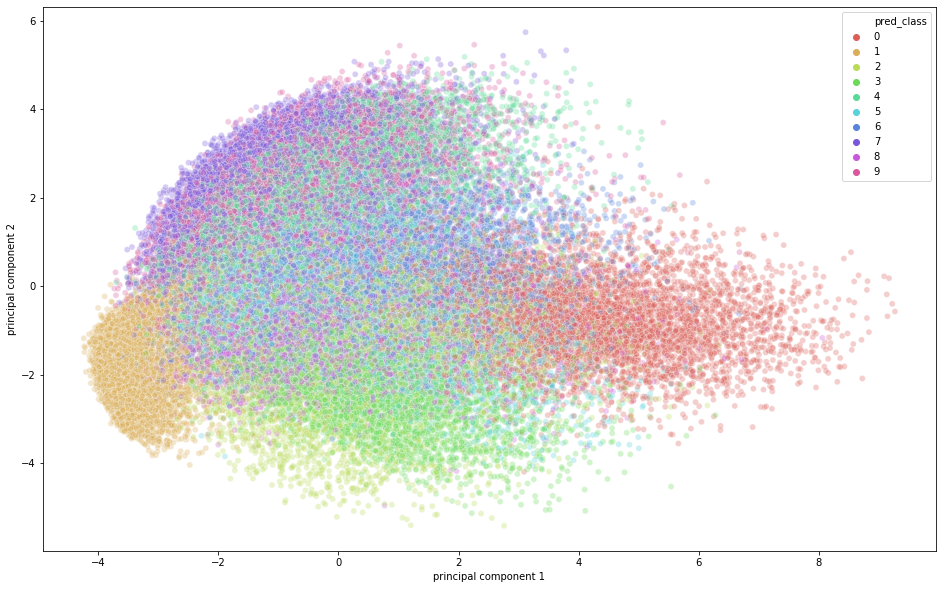

In [60]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="pred_class",
    palette=sns.color_palette("hls", 10),
    data=pixel_pca_df,
    legend="full",
    alpha=0.3
)

### Step 8:  Use PCA decomposition to reduce the (activation) features from 128 (= num of hidden nodes) to 2

In [61]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values 

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,-1.465286,7.793158
1,12.128675,-0.411425
2,4.605544,-7.474449
3,-4.475563,1.280452
4,-3.514421,-8.992661


In [62]:
activation_pca_df = pd.concat([principalDf, activation_df[['pred_class']]], axis = 1)
activation_pca_df.head()

,principal component 1,principal component 2,pred_class
0,-1.465286,7.793158,5
1,12.128675,-0.411425,0
2,4.605544,-7.474449,4
3,-4.475563,1.280452,1
4,-3.514421,-8.992661,9


In [63]:
pca.explained_variance_ratio_

array([0.15382616, 0.12555717], dtype=float32)

### Step 9:  Using a scatter plot to visualize the contribution of *two* principal component values to the predicated class values

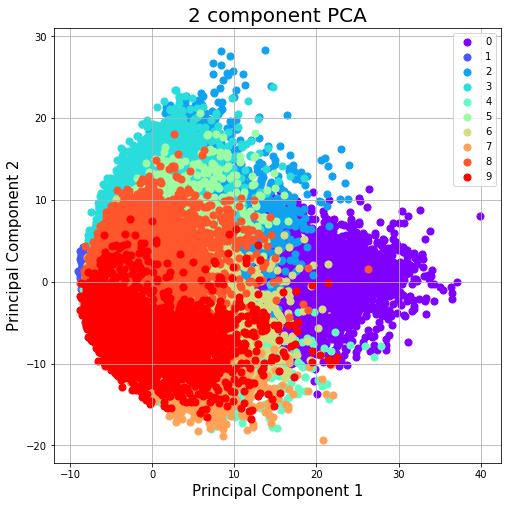

In [64]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2,3,4,5,6,7,8,9]
#colors = ['r', 'g', 'b']
from matplotlib import cm


colors = cm.rainbow(np.linspace(0, 1, 10))

for target, color in zip(targets,colors):
    indicesToKeep = activation_pca_df['pred_class'] == target
    ax.scatter(activation_pca_df.loc[indicesToKeep, 'principal component 1']
               , activation_pca_df.loc[indicesToKeep, 'principal component 2']
               , c = color.reshape(1,-1)
               , s = 50)
ax.legend(targets)
ax.grid()

Using seaborn this time

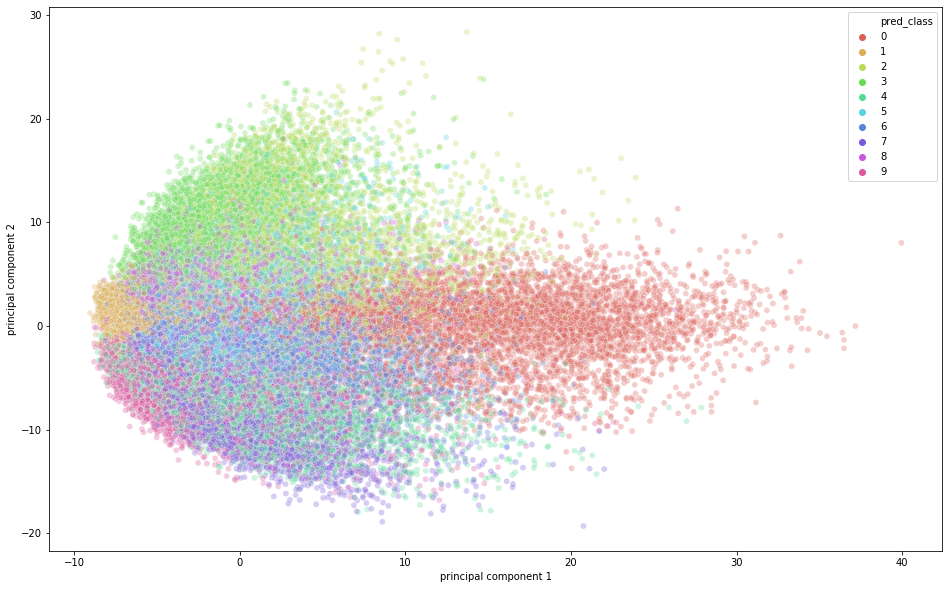

In [65]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="principal component 1", y="principal component 2",
    hue="pred_class",
    palette=sns.color_palette("hls", 10),
    data=activation_pca_df,
    legend="full",
    alpha=0.3
)

### Step 10:  Use PCA decomposition to reduce the (activation) features from 128 (= num of hidden nodes) to 3

In [66]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values 

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca-one', 'pca-two', 'pca-three'])
principalDf.head()

,pca-one,pca-two,pca-three
0,-1.465526,7.793057,5.316390
1,12.128677,-0.411442,-2.601506
2,4.605549,-7.474424,-1.509205
3,-4.475564,1.280479,-2.726787
4,-3.514424,-8.992652,2.966942


In [67]:
pca.explained_variance_ratio_

array([0.15382637, 0.12555745, 0.09169675], dtype=float32)

In [68]:
activation_pca_df = pd.concat([principalDf, activation_df[['pred_class']]], axis = 1)
activation_pca_df.head()

,pca-one,pca-two,pca-three,pred_class
0,-1.465526,7.793057,5.316390,5
1,12.128677,-0.411442,-2.601506,0
2,4.605549,-7.474424,-1.509205,4
3,-4.475564,1.280479,-2.726787,1
4,-3.514424,-8.992652,2.966942,9


### Step 11:  Using a scatter plot to visualize the contribution of *three* principal component values to the predicated class values

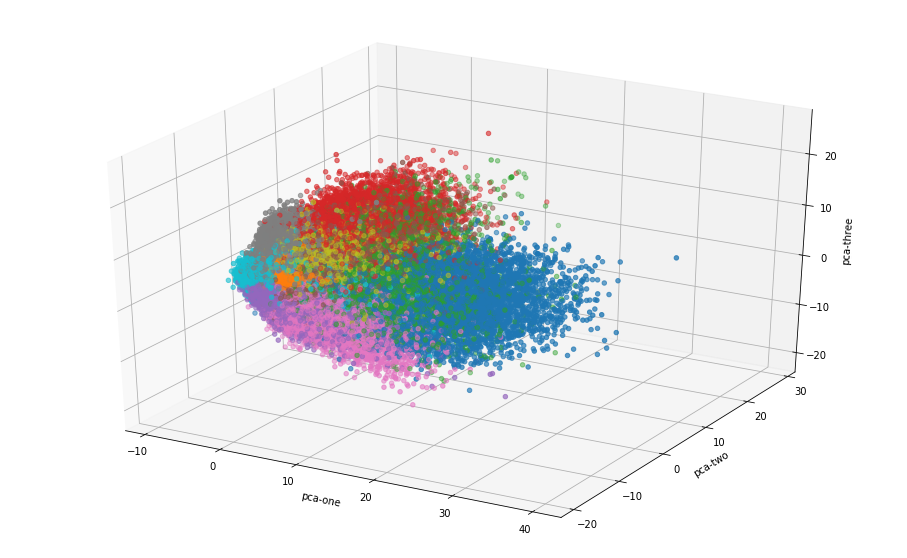

In [69]:
# uncomment to to able to rotate the graph...
# %matplotlib notebook   
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=activation_pca_df.loc[:,"pca-one"], 
    ys=activation_pca_df.loc[:,"pca-two"], 
    zs=activation_pca_df.loc[:,"pca-three"], 
    c=activation_pca_df.loc[:,"pred_class"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### Step 12:  Use t-Distributed Stochastic Neighbor Embedding (**t-SNE**)  to reduce the (activation) features from 128 (= num of hidden nodes) to 2

`t-Distributed Stochastic Neighbor Embedding` (**t-SNE**) is another technique for dimensionality reduction and is particularly well suited for the visualization of high-dimensional datasets. This time we only use the first 10,000 training images (N=10000) since the technique is computationally expensive.

See http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

In [70]:
N=10000
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

(10000, 129)

In [71]:
data_subset = activation_df_subset[features].values
data_subset.shape

(10000, 128)

In [72]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.395s...
[t-SNE] Computed neighbors for 10000 samples in 30.344s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 3.851560
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.377808
[t-SNE] KL divergence after 300 iterations: 2.610229


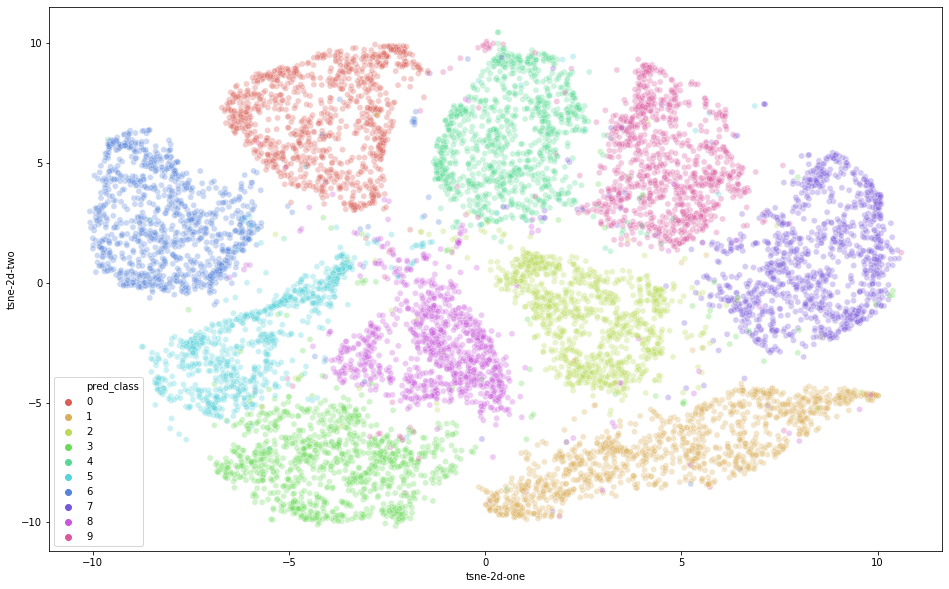

In [73]:
activation_df_subset['tsne-2d-one'] = tsne_results[:,0]
activation_df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="pred_class",
    palette=sns.color_palette("hls", 10),
    data=activation_df_subset,
    legend="full",
    alpha=0.3
)

## Task 11: Reducing dimensionality of the data with Random Forests.

We create a Random Forrest Classifier (with the default 100 trees) and use it to find the relative importance of the 784 features (pixels) in the training set. We produce a heat map to visual the relative importance of the features (using code from Hands On Machine Learning by A. Geron). Finally, we select the 70 most important feature (pixels) from the training, validation and test images to test our 'best' model on.

In [74]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(x_train_norm,y_train_encoded)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

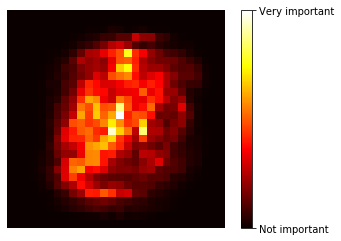

In [75]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = 'hot',
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])
plt.show()

In [76]:
# https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
n = 70
imp_arr = rnd_clf.feature_importances_
idx = (-imp_arr).argsort()[:n]          # get the indices of the 70 "most important" features/pixels
len(idx)

70

In [77]:
# Create training and test images using just the 70 pixel locations obtained above
train_images_sm = x_train_norm[:,idx]
test_images_sm = x_test_norm[:,idx]
train_images_sm.shape, test_images_sm.shape # the reduced images have dimension 70

((60000, 70), (10000, 70))

### Visualizing the 70 pixels
We convert the array of indexes to ordered pairs and plot them as red circles on the second training image. These are the features (pixels) we train our neural network on.

In [78]:
# to convert an index n, 0<= n < 784
def pair(n,size):
    x = n//size 
    y = n%size
    return x,y

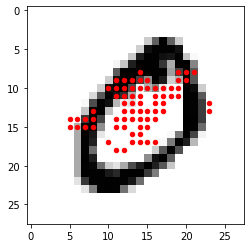

In [79]:
plt.imshow(x_train_norm[1].reshape(28,28),cmap='binary')
x, y = np.array([pair(k,28) for k in idx]).T
plt.scatter(x,y,color='red',s=20)